In [1]:
%matplotlib inline
import numpy as np
from onezone.analysis import analysis_tools as atools
import matplotlib.pyplot as plt

from astropy import units as u
from collections import OrderedDict
from galaxy_analysis.analysis import Galaxy 

from scipy.stats import gaussian_kde

simdir = '/home/aemerick/work/enzo_runs/sn_H2atten_H2sh'
workdir  = simdir + '/onezone/sfr_sim/'

from galaxy_analysis.plot.plot_styles import *

/home/aemerick/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/aemerick/code/galaxy_analysis/particle_analysis/IMF.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/aemerick/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/aemerick/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/aemerick/anaconda2/lib/python2.7/sit

/home/aemerick/code/galaxy_analysis/particle_analysis/sn_rate.py:4: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/aemerick/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/aemerick/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/aemerick/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/aemerick/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/aemerick/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", li

/home/aemerick/code/galaxy_analysis/plot/plot_styles.py:7: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/aemerick/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/aemerick/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/aemerick/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/aemerick/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/aemerick/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 477, i

In [2]:

import matplotlib as mpl
import pylab as pl

def multidigitize(x,y,binsx,binsy):
    dx = np.digitize(x.flat, binsx)
    dy = np.digitize(y.flat, binsy)
    return dx,dy

def linlogspace(xmin,xmax,n):
    return np.logspace(np.log10(xmin),np.log10(xmax),n)

def adaptive_param_plot(x,y,
                        bins=10,
                        threshold=5,
                        marker='.',
                        marker_color=None,
                        ncontours=5,
                        levels=None,
                        fill=False,
                        mesh=False,
                        contourspacing=linlogspace,
                        mesh_alpha=0.5,
                        norm=None,
                        axis=None,
                        cmap=None,
                        **kwargs):
    """
    Plot contours where the density of data points to be plotted is too high
    Many of these parameters are just passed on to matplotlib's "plot" and
    "contour" functions
    Parameters
    ----------
    bins: int or ndarray
        The number of bins or a list of bins.  Passed to np.histogram2d; see
        their docs for details
    threshold: int
        The minimum number of points to replace a bin with a contour.  For
        npoints<=threshold, the individual points will be plotted
    marker: str
        Any valid marker (see matplotlib.plot)
    marker_color: str
        Any valid marker color
    ncontours: int
        Number of contour levels
    levels: None or list 
        Optional override for automatically computed levels
    fill: bool
        Use filled contours?
    mesh: bool
        Use a color mesh instead of contours (i.e., filled pixels)
    contourspacing: function
        A function to determine the contour spacing.  Should be 
        np.linspace or the linlogspace function
        defined above.  The function must accept arguments of:
        lowest contour level, highest contour level, number of contours
    mesh_alpha: float
        Alpha opacity parameter of the colormesh, if used
    norm: matplotlib.colors.Normalize
        A normalization to use for the contours or colormesh
    axis: None or matplotlib.Axes
        A matplotlib axis to plot on
    cmap: matplotlib colormap
        A valid matplotlib color map
    kwargs: dict
        Passed to plot, contour, AND colormesh, so must be valid for ALL 3!
    """
    
    if axis is None:
        axis = pl.gca()

    ok = np.isfinite(x) * np.isfinite(y)

    # set the number of bins to be an integer value, which can be extracted
    # from an array-style bin set
    if hasattr(bins,'ndim') and bins.ndim == 2:
        nbinsx = bins[0]
        nbinsy = bins[1]
        # If you define the bins as an array, they define the BIN EDGES, so nbins=len(bins)-1
        #nbinsx,nbinsy = bins.shape[0]-1,bins.shape[1]-1
    else:
        try:
            nbinsx = nbinsy = len(bins)-1
        except TypeError:
            nbinsx = nbinsy = bins

    H,bx,by = np.histogram2d(x[ok],y[ok],bins=bins)

    # determine the locations of each pixel
    dx,dy = multidigitize(x[ok],y[ok],bx,by)

    # anything beyond the range of the histogram bins defaults to plottable=True
    # need +1 because anything <bins.min() or >bins.max() is on the edges...
    plottable = np.ones([nbinsx+2,nbinsy+2], dtype='bool')
    # Need a cropped version of "plottable" to index H
    # This is a view on plottable, so should result in inplace modification...
    # (this version does not include the points > bins.max() and < bins.min(),
    # which will all be plotted)
    plottable_hist = plottable[1:-1,1:-1]
    assert H.shape == plottable_hist.shape
    # points are plottable if below the threshold
    plottable_hist[H > threshold] = False

    #H[plottable] = np.nan
    H[plottable_hist] = 0
    #H = np.ma.masked_where(plottable,H)
    toplot = plottable[dx,dy]

    cx = (bx[1:]+bx[:-1])/2.
    cy = (by[1:]+by[:-1])/2.
    if levels is None:
        levels = contourspacing(threshold-0.5,H.max(),ncontours)
    #levels = contourspacing(0,H.max(),ncontours)

    if cmap is None:
        cmap = mpl.cm.get_cmap()
        cmap.set_under((0,0,0,0))
        cmap.set_bad((0,0,0,0))

    if fill:
        con = axis.contourf(cx,cy,H.T,levels=levels,norm=norm,cmap=cmap,**kwargs)
    else:
        con = axis.contour(cx,cy,H.T,levels=levels,norm=norm,cmap=cmap,**kwargs)
    if mesh:
        mesh = axis.pcolormesh(bx,by,H.T, **kwargs)
        mesh.set_alpha(mesh_alpha)
    
    if 'linestyle' in kwargs:
        kwargs.pop('linestyle')

    if marker not in ('none', None):
        axis.plot(x[ok][toplot],
                  y[ok][toplot],
                  linestyle='none',
                  marker=marker,
                  markerfacecolor=marker_color,
                  markeredgecolor=marker_color,
                  **kwargs)

    return cx,cy,H,x[ok][toplot],y[ok][toplot]

In [3]:
def density_estimation(m1, m2):
    xmin = np.min(m1)
    xmax = np.max(m1)
    
    ymin = np.min(m2)
    ymax = np.max(m2)
    
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]                                                     
    positions = np.vstack([X.ravel(), Y.ravel()])                                                       
    values = np.vstack([m1, m2])                                                                        
    kernel = gaussian_kde(values)                                                                 
    Z = np.reshape(kernel(positions).T, X.shape)
    return X, Y, Z

In [4]:


class OnezoneAbundances:
    
    def __init__(self, filename):
        
        self.filename  = filename
        self.data     = np.genfromtxt(self.filename,names=True)
        
        
        self.elements  = [x for x in np.array(self.data.dtype.names[7:])]
        
        self.retention_factors = OrderedDict()
        for e in self.elements:
            self.retention_factors[e] = 1.0
        
        self.current_time = None
        
        return
    
    def abundance_ratio(self, e1, e2, mask = None, filtered_data = True, normalize = 'solar'):
        
        if filtered_data:
            _data = self.filtered_data
        else:
            _data = lambda x : self.data[x]
        
        x1 = (_data(e1) * _data('M') * u.Msun).to('g').value # mass in solar
        x2 = (_data(e2) * _data('M') * u.Msun).to('g').value # mass in solar

        select = (x1 > 0.0)*(x2 > 0.0)
        
        x1 = x1[select]
        x2 = x2[select]
        
        result = np.zeros(np.size(x1))
        for i in np.arange(np.size(x1)):
            result[i] = atools.abundance_ratio( (e1,x1[i]), 
                                                          (e2,x2[i]), input_type = 'mass',
                                                          normalize = normalize)
        
        
        return result
    
    def filtered_data(self, key):
        
        select = np.array([True]*np.size(self.data['M']))
        
        if not (self.current_time is None):
            formation_time = (self.data['t']*u.Myr).value
            death_time     = ((self.data['t']*u.Myr + self.data['lifetime']*u.s).to("Myr")).value
            
            select = (self.current_time > formation_time)*(self.current_time<death_time)
            
        vals = self.data[key][select]
        
        if key in self.elements:
            
            vals = vals * self.retention_factors[key]
        
        return vals

In [5]:
def plot_ratios(x1,x2,y1,y2,axis=None, normalize = 'solar'):
    """
    Plot abundance ratios [y1/y2] vs. [x1/x2] using contours
    for the onezone runs and scatter points for simulation dataset
    """
    if axis is None:
        fig, ax = plt.subplots()
    else:
        ax = axis
    
    all_x = []
    all_y = []
    for data in all_data:
        y = data.abundance_ratio(y1,y2, filtered_data = True,normalize=normalize)
        x = data.abundance_ratio(x1,x2, filtered_data = True,normalize=normalize)
    
        all_x += [x*1.]
        all_y += [y*1.]
    
    all_x = np.hstack(all_x)
    all_y = np.hstack(all_y)
    
    cx,cy,H,fx, fy = adaptive_param_plot(all_x,all_y, bins = 32,
                                       axis = ax, ncontours=7, cmap = 'magma')

    #cx,cy,H,fx, fy = adaptive_param_plot(x,y, bins = 32,
    #                                   axis = ax, ncontours=7, cmap = 'viridis')
    ax.scatter(x,y,color='C0',marker='o',alpha=0.5,s=10, label = 'Ex. Onezone')

    sim_x = gal.df[('io','particle_'+x1+'_over_'+x2)].value
    sim_y = gal.df[('io','particle_'+y1+'_over_'+y2)].value
    
    if not  (normalize == 'solar'):
        sim_x = atools.renormalize_abundances(sim_x, x1, x2, 'solar',normalize)
        sim_y = atools.renormalize_abundances(sim_y, y1, y2, 'solar',normalize)
                                            

    
    ax.scatter(sim_x,sim_y, color = 'C1', marker = '*', alpha = 0.5, s = 10, label = 'Simulation')
    
    return all_x, all_y, sim_x, sim_y


In [6]:
AGB_retention = 0.25
metal_retention = 0.05

gal = Galaxy('DD0871', wdir = simdir)

all_data = [None]*28
for i in np.arange(28):
    datafile = workdir + "run%0004i_abundances.dat"%(i)
    all_data[i] = OnezoneAbundances(datafile)
    
    for e in all_data[i].elements:
        all_data[i].retention_factors[e] = metal_retention
        
    all_data[i].retention_factors['H']  = 0.75
    all_data[i].retention_factors['He'] = 0.75
    all_data[i].retention_factors['Ba'] = AGB_retention
    all_data[i].retention_factors['N']  = AGB_retention
    


Parsing Hierarchy : 100%|██████████| 290/290 [00:00<00:00, 47902.81it/s]
/home/aemerick/anaconda2/lib/python2.7/site-packages/yt/fields/local_fields.py:46: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
  warnings.warn("Because 'sampling_type' not specified, yt will "


tracer species present:  ['C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
16 mass fields defined
16 mass fraction fields defined
15 number density fields defined
6 ionization state fields defined
141 abundance ratio fields defined
141 particle abundance ratio fields defined
5 additional helper fields defined


Parsing Hierarchy : 100%|██████████| 1227/1227 [00:00<00:00, 49809.44it/s]
/home/aemerick/code/onezone/data_tables.py:96: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if  c == flag or id == flag:


Text(0,0.5,u'[Mg/Fe]')

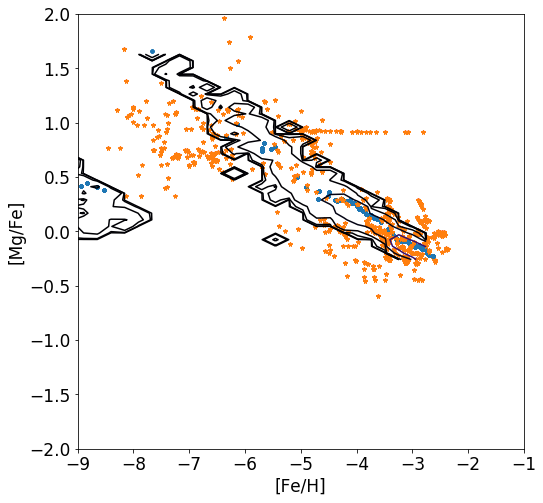

In [7]:
fig, ax = plt.subplots()
fig.set_size_inches(8,8)



all_x = []
all_y = []
for data in all_data:
    y = data.abundance_ratio('Mg','Fe', filtered_data = True)
    x = data.abundance_ratio('Fe','H', filtered_data = True)
    
    all_x += [x*1.]
    all_y += [y*1.]
    
all_x = np.hstack(all_x)
all_y = np.hstack(all_y)
    


cx,cy,H,fx, fy = adaptive_param_plot(all_x,all_y, bins = 32,
                                   axis = ax, ncontours=7, cmap = 'magma')

#cx,cy,H,fx, fy = adaptive_param_plot(x,y, bins = 32,
#                                   axis = ax, ncontours=7, cmap = 'viridis')
ax.scatter(x,y,color='C0',marker='o',alpha=0.5,s=10)

ax.scatter(gal.df[('io','particle_Fe_over_H')].value, 
           gal.df[('io','particle_Mg_over_Fe')].value, color = 'C1', marker = '*', alpha = 0.5, s = 10)


ax.set_xlim(-9,-1)
ax.set_ylim(-2,2)
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('[Mg/Fe]')

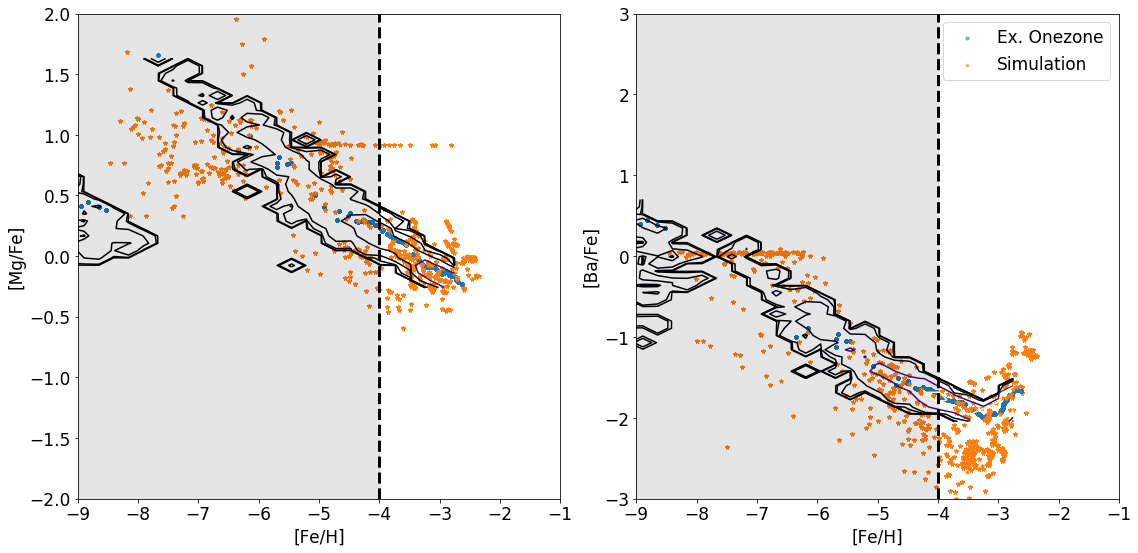

In [8]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(16,8)


d = plot_ratios('Fe','H','Mg','Fe', axis = ax[0])
d = plot_ratios('Fe','H','Ba','Fe', axis = ax[1])

ax[0].set_xlim(-9,-1)
ax[0].set_ylim(-2,2)
ax[0].set_xlabel('[Fe/H]')
ax[0].set_ylabel('[Mg/Fe]')

ax[1].set_xlim(-9,-1)
ax[1].set_ylim(-3,3)
ax[1].set_xlabel('[Fe/H]')
ax[1].set_ylabel('[Ba/Fe]')

ax[1].legend(loc = 'best')

ax[0].plot( [-4,-4], ax[0].get_ylim(),lw = 3, ls = '--', color='black')
ax[1].plot( [-4,-4], ax[1].get_ylim(),lw = 3, ls = '--',color='black')

ax[0].axvspan(-9,-4, alpha=0.1, color='black')
ax[1].axvspan(-9,-4, alpha=0.1, color='black')


plt.tight_layout()

fig.savefig(workdir + 'MgFe_FeH_BaFe_FeH.png')

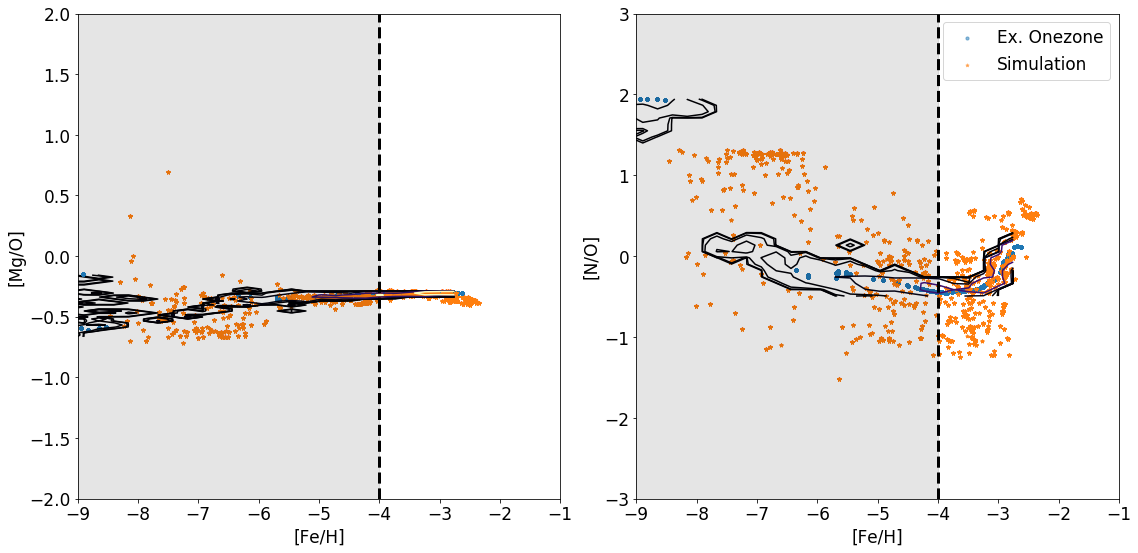

In [9]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(16,8)


d = plot_ratios('Fe','H','Mg','O', axis = ax[0])
d = plot_ratios('Fe','H','N','O', axis = ax[1])

ax[0].set_xlim(-9,-1)
ax[0].set_ylim(-2,2)
ax[0].set_xlabel('[Fe/H]')
ax[0].set_ylabel('[Mg/O]')

ax[1].set_xlim(-9,-1)
ax[1].set_ylim(-3,3)
ax[1].set_xlabel('[Fe/H]')
ax[1].set_ylabel('[N/O]')

ax[1].legend(loc = 'best')

ax[0].plot( [-4,-4], ax[0].get_ylim(),lw = 3, ls = '--', color='black')
ax[1].plot( [-4,-4], ax[1].get_ylim(),lw = 3, ls = '--',color='black')

ax[0].axvspan(-9,-4, alpha=0.1, color='black')
ax[1].axvspan(-9,-4, alpha=0.1, color='black')


plt.tight_layout()

fig.savefig(workdir + 'MgO_FeH_NO_FeH.png')

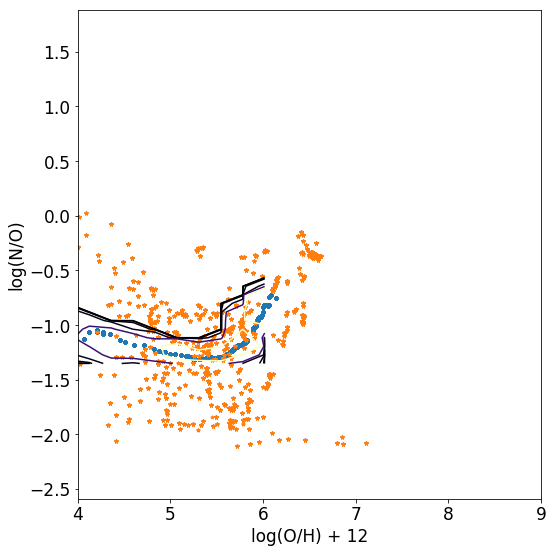

In [14]:
fig, ax = plt.subplots()
fig.set_size_inches(8,8)


d = plot_ratios('O','H','N','O', axis = ax, normalize = 'gas')

#ax.set_xlim(-9,-1)
#ax.set_ylim(-2,2)
ax.set_xlabel('log(O/H) + 12')
ax.set_ylabel('log(N/O)')

#ax[0].plot( [-4,-4], ax[0].get_ylim(),lw = 3, ls = '--', color='black')
#ax[1].plot( [-4,-4], ax[1].get_ylim(),lw = 3, ls = '--',color='black')

#ax[1].axvspan(-9,-4, alpha=0.1, color='black')

ax.set_xlim(4,9)

plt.tight_layout()

fig.savefig(workdir + 'NO_logOH.png')

(-3, 3)

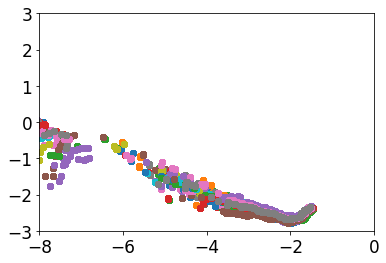

In [11]:
fig, ax = plt.subplots()


for data in all_data:
    y = data.abundance_ratio('Ba','Fe',filtered_data=False)
    x = data.abundance_ratio('Fe','H', filtered_data=False)
    ax.scatter(x,y)
ax.set_xlim(-8,0)
ax.set_ylim(-3,3)